<center><h1>Analiza modelu GPT-2 pod kątem algebry liniowej</h1></center>
<center>Współautorzy: Daniel Nazaruk, Adam Gryniewski, Hubert Parzych, Michał Badura, Michał Zwierzyński, Oliwia Łankiewicz</center>

---

<center><h1>Wprowadzenie teorytyczne<h1></center>

<h3>1.1 Definicja GPT</h3>

<b>GPT</b> to akronim od:
* <b>Generative: </b>Model służy do generowania kolejnych elementów.
* <b>Pre-Trained: </b> Model przeszedł proces uczenia z ogromnej ilości danych. (W przypadku GPT2 ok. 40 GB tekstu)
* <b>Transformer: </b> Architektura oparta na mechanizmie Self-Attention, który jest sekwencją operacji na macierzach Q,K,V, wyrażoną wzorem:
  $$ \text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V $$

Co ciekawe, GPT-2 jest modelem typu base, którego celem jest jedynie dokończenie tekstu w przeciwieństwie do współczesnych chatbotów, które przewidują kolejne słowa z perspektywy narzuconej im persony moralnego asystenta, co sprawia, że zamiast tylko generować tekst, faktycznie odpowiadają na pytania użytkownika.

<h3>1.2 Proces przetwarzania</h3>

Przy generowaniu odpowiedzi, model rozpoczyna od podziału tekstu wejściowego (promptu) na mniejsze jednostki nazywane tokenami. W przypadku, gdzie wejście jest w postaci tekstu mogą one reprezentować pełne słowa, ich fragmenty lub inne często występujące kombinacje znaków. Następnie każdy z tych tokenów jest rzutowany na odpowiadający mu wektor w wielowymiarowej przestrzeni (embedding). Wektor ten matematycznie koduje semantyczne znaczenie tokenu, dzięki czemu tokeny o podobnym znaczeniu mają bliskie pozycje w tej przestrzeni.

Tak przygotowana macierz trafia do bloku Attention, którego zadaniem jest modelowanie relacji między wszystkimi tokenami jednocześnie. Mechanizm attention pozwala na zrozumienie kontekstu i wieloznaczności – posłużmy się przykładem słowa "zamek". Bez kontekstu nie jest wiadome, czy chodzi o budowlę, zamek w drzwiach, czy może zamek błyskawiczny. Wektor dla słowa "zamek" na wejściu nie jest ani budowlą, ani suwakiem, jest matematyczną średnią wszystkich sytuacji, w jakich model widział to słowo podczas treningu. Na tym etapie rozpoznajemy które słowa w kontekście wpływają na pozostałe słowa i jak powinny zostać zmienione, aby uzyskać ich prawdziwe znaczenie.

Celem tego procesu jest wkomponowanie całej informacji kontekstowej w ostatni wektor. Ten finalny wektor służy do wygenerowania rozkładu prawdopodobieństwa, który pokazuje, jakie słowo powinno wystąpić jako następne. 

<h3>1.3 Architektura</h3>

<center><img src="https://raw.githubusercontent.com/USomsiadZ/gpt_projekt/refs/heads/main/porownanie.gif" width="700"></center>
<center>wizualizacja modeli GPT2-small, GPT2-XL, GPT3</center>
<br>
<br>
<center>GPT-2 Small posiada łącznie ok. 124 miliony parametrów, które są podzielone na 470 macierzy.</center>

| Kategoria | Wymiary | Liczba parametrów |
| :--- | :--- | :--- |
| **Token Embedding** | $50,257 \times 768$ <br> $n_{vocab} \times d_{embed}$ | $= \mathbf{38,597,376}$ |
| **Positional Embedding** | $1,024 \times 768$ <br> $n_{ctx} \times d_{embed}$ | $= \mathbf{786,432}$ |
| **Key (K)** | $64 \times 768 \times 12 \times 12$ <br> $d_{head} \times d_{embed} \times n_{heads} \times n_{layers}$ | $= \mathbf{7,077,888}$ |
| **Query (Q)** | $64 \times 768 \times 12 \times 12$ <br> $d_{head} \times d_{embed} \times n_{heads} \times n_{layers}$ | $= \mathbf{7,077,888}$ |
| **Value (V)** | $64 \times 768 \times 12 \times 12$ <br> $d_{head} \times d_{embed} \times n_{heads} \times n_{layers}$ | $= \mathbf{7,077,888}$ |
| **Output (Attention)** | $768 \times 768 \times 12$ <br> $d_{embed} \times d_{out} \times n_{layers}$ | $= \mathbf{7,077,888}$ |
| **Up-projection (MLP)** | $3072 \times 768 \times 12$ <br> $n_{neurons} \times d_{embed} \times n_{layers}$ | $= \mathbf{28,311,552}$ |
| **Down-projection (MLP)** | $768 \times 3072 \times 12$ <br> $d_{embed} \times n_{neurons} \times n_{layers}$ | $= \mathbf{28,311,552}$ |
| **Unembedding** | $50,257 \times 768$ <br> *(Współdzielone z Token Embedding)* | $= \mathbf{0}$ *(Shared)* |
| **Layer Norms & Biases** | Wektory pomocnicze (biasy, scale) | $\approx \mathbf{121,344}$ |
| Suma | | **124,439,808** |

---

<center><h1>Rozwiązania poszczególnych zadań projektowych<h1></center>

<h2>1. Wystawienie modelu</h2>

In [1]:
#!pip install transformers torch fastapi uvicorn nest-asyncio scikit-learn
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_name="gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)#tokenizer zamienia słowo na ID tokenów
tokenizer.pad_token=tokenizer.eos_token #zamienia token dopełnienia PAD na token końca sekwencji EOS |GPT2 nie posiada własnego tokena pad
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval() #tryb ewaluacji


if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

<h2>2. Opis struktur macierzy K,V,Q,E</h2>

<center><h1>Macierz embedding</h1></center>

Macierz embedding oznaczamy jako $W_E$ . Model GPT2 ma predefiniowany słownik składający się z $V = 50\,257$ tokenów. 

Dla każdego z tych tokenów odpowiada jedna kolumna tej macierzy. Każda kolumna (w przypadku modelu GPT2-small) stanowi 768-wymiarowy wektor cech. Oznacza to, że macierz embedding ma wymiary $768 \times50\,257$. Na podstawie tego możemy obliczyć wartość wszystkich parametrów w macierzy embedding.

In [2]:
we = model.transformer.wte.weight
print("kształt macierzy embedding:", we.shape)

kolumny = we.shape[0]
wiersze = we.shape[1]
parametry = kolumny*wiersze
print("wszystkie parametry w macierzy embedding:", parametry)

kształt macierzy embedding: torch.Size([50257, 768])
wszystkie parametry w macierzy embedding: 38597376


<center><h1>Macierze Q,K,V</h1></center>

W bloku self attention wykorzystujemy trzy macierze wag, które oznaczamy jako $W_Q$ (Query), $W_K$ (Key), $W_V$ (Value). W modelu GPT2-small ich wymiary wynoszą $768 \times768$, choć technicznie są one podzielone na niezależne podprzestrzenie zwane głowicami.

Model posiada 12 głowic. Oznacza to, że obliczony wektor zapytania $q$  o długości 768 w rzeczywistości składa się z 12 mniejszych wektorów, każdy o wymiarze:

<center><h4>$d_{head} = \frac{768}{12} = 64$</h4></center>

* **wiersze** odpowiadają wymiarowi wejściowemu – macierz musi przyjąć wektor embeddingu o długości 768.
* **kolumny** odpowiadają wymiarowi wyjściowemu – wynikiem mnożenia jest nowy wektor, który również ma długość 768.

Mnożąc wektor konkretnego tokena przez macierz $W_Q$ otrzymujemy wektor zapytania $q$, który szuka konkretnych cech

Mnożąc wektor konkretnego tokena przez macierz $W_K$ otrzymujemy wektor klucza $k$, który reklamuje konkretne cechy

Mnożąc wektor konkretnego tokena przez macierz $W_V$ otrzymujemy wektor wartości $v$, który zawiera treść, która zostanie przekazana dalej, jeśli $q$ i $k$ będą do siebie pasować.


In [3]:
e = model.transformer.wte.weight[100] 

W_QKV = model.transformer.h[0].attn.c_attn.weight

W_Q = W_QKV[:, 0:768]
W_K = W_QKV[:, 768:1536]
W_V = W_QKV[:, 1536:]
print("kształt W_Q:", W_Q.shape)
print("kształt W_K:", W_K.shape)
print("kształt W_V:", W_V.shape)

# wektor tokena*macierz
q = torch.matmul(e, W_Q)
k = torch.matmul(e, W_K)
v = torch.matmul(e, W_V)
print("")
print("wektor q:", q.shape)
print("wektor k:", k.shape)
print("wektor v:", v.shape)

n_head = model.config.n_head
head_dim = q.shape[0] // n_head
print("")
print("liczba głowic w modelu:", n_head)
print("rzeczywisty wymiar wektora jednej głowicy:", head_dim)

kształt W_Q: torch.Size([768, 768])
kształt W_K: torch.Size([768, 768])
kształt W_V: torch.Size([768, 768])

wektor q: torch.Size([768])
wektor k: torch.Size([768])
wektor v: torch.Size([768])

liczba głowic w modelu: 12
rzeczywisty wymiar wektora jednej głowicy: 64


<h2>3. Opis wartości $e_i$ dla pewnych tokenów</h2>

<center><h1>Czym jest $e_i$ w macierzy embedding</h1></center>

Jeżeli embedding danego tokenu ma postać:

$$\mathbf{e} = (e_1, e_2, e_3, \dots, e_d)$$

to każda wartość $e_i$ oznacza **i-tą współrzędną tego wektora**. Jest to pojedyncza liczba rzeczywista opisująca udział tokenu w pewnej abstrakcyjnej cesze znaczeniowej.

W GPT-2 wymiar wektora embeddingu wynosi zazwyczaj $d = 768$, co oznacza, że każdy token opisany jest przez 768 wartości $e_i$.

<center><h1>Tokenizacja BPE</h1></center>

Proces zamiany tekstu na wektory jest fundamentem algebry liniowej w modelu GPT-2. Składa się on z mechanizmu Byte Pair Encoding oraz rzutowania na przestrzeń wysokowymiarową.
BPE operuje na poziomie sub-tokenów, iteracyjnie łączy najczęstsze pary bajtów, tworząc słownik o rozmiarze $V = 50\,257$. Rozwiązuje problem Out-of-Vocabulary (OOV) – każde słowo można rozbić na znane modelowi fragmenty (np. tokenization $\to$ token, iz, ation). 

Tekst zamieniany jest na sekwencję indeksów $k \in \{0, \dots, V-1\}$. Każdy indeks $k$ jest mapowany na gęsty wektor przy użyciu macierzy wag $W_E \in \mathbb{R}^{V \times d}$ (gdzie $d = 768$). Formalnie:$$\mathbf{e} = \mathbf{x} \cdot W_E$$gdzie $\mathbf{x}$ to wektor one-hot (jedynka na pozycji $k$). W praktyce jest to operacja lookup table – pobranie $k$-tego wiersza macierzy.

<center><h1>Jak działają wartości $e_i$</h1></center>

Wartości $e_i$ nie mają z góry ustalonego znaczenia i nie są interpretowalne wprost przez człowieka. Są one **wyuczone automatycznie** podczas treningu GPT-2. Każda wartość $e_i$ reprezentuje pewien ukryty wymiar semantyczny.

Z punktu widzenia algebry liniowej istotne jest to, że:
- pojedyncze $e_i$ nie niesie pełnej informacji,
- znaczenie tokenu zawarte jest w **całym wektorze embeddingu**,
- podobieństwo tokenów można mierzyć za pomocą miar geometrycznych.

In [4]:
tokens = ["king", "man", "brother", "father", "Jesus", "Hitler", "queen", "woman", "sister", "mother", "daughter"]

def get_embedding(token):
    tid = tokenizer.encode(token, add_special_tokens=False)[0]
    return model.transformer.wte.weight[tid].detach()

emb = {t: get_embedding(t) for t in tokens}

<center><h1>Geometryczne porównanie embeddingów</h1></center>
Rozważmy przykład teoretyczny porówania współrzędnych $e_i$ dla uproszczonego wymiaru:

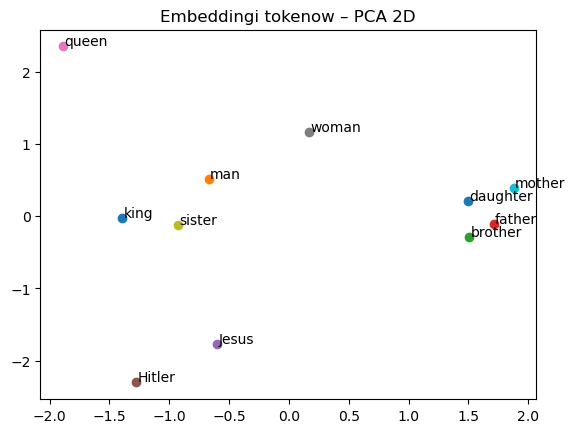

In [5]:
X = np.array([emb[t].detach().cpu().numpy() for t in tokens])

pca2 = PCA(n_components=2)
X2 = pca2.fit_transform(X)

plt.figure()
for i, t in enumerate(tokens):
    plt.scatter(X2[i,0], X2[i,1])
    plt.text(X2[i,0]+0.01, X2[i,1]+0.01, t)
plt.title("Embeddingi tokenow – PCA 2D")
plt.show()

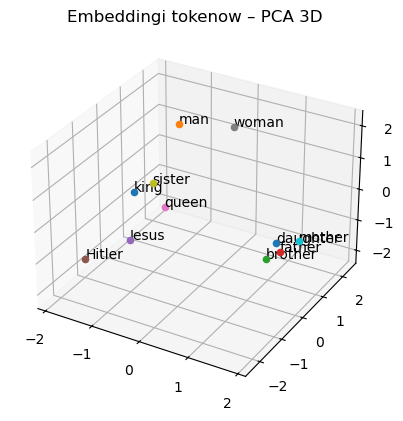

In [6]:
pca3 = PCA(n_components=3)
X3 = pca3.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for i, t in enumerate(tokens):
    ax.scatter(X3[i,0], X3[i,1], X3[i,2])
    ax.text(X3[i,0], X3[i,1], X3[i,2], t)

ax.set_title("Embeddingi tokenow – PCA 3D")
plt.show()

<center><h1>Podobieństwo cosinusowe embeddingów</h1></center>

Zmiana tokenu powoduje zmianę wielu wartości $e_i$, co przesuwa punkt reprezentujący token w przestrzeni $\mathbb{R}^d$. Dzięki temu podobieństwo semantyczne odpowiada bliskości w przestrzeni.

In [7]:
sim_mother_father = F.cosine_similarity(emb["mother"], emb["father"], dim=int(0))
sim_man_woman = F.cosine_similarity(emb["man"], emb["woman"], dim=int(0))
sim_jezus_hitler = F.cosine_similarity(emb["Jesus"], emb["Hitler"], dim=int(0))

print("Cosine similarity matka-ojcec:", sim_mother_father.item())
print("Cosine similarity mężczyzna–kobieta:", sim_man_woman.item())
print("Cosine similarity Jezus–Hitler:", sim_jezus_hitler.item())

Cosine similarity matka-ojcec: 0.7019220590591431
Cosine similarity mężczyzna–kobieta: 0.5863356590270996
Cosine similarity Jezus–Hitler: 0.369886577129364


<h2>4. Opis układu prawdopodobieństwa kolejnych tokenów</h2>

In [8]:
words = ["The name of the day today is","in ABBBA the count of letter B is","statement that the number 2/0 is rational is", "Tom's mother has four children: North, South, East, and", "the answer to the meaning of life is simply to"]

# Tokeny GPT-2
tokens = [tokenizer.encode(w, add_special_tokens=False) for w in words]
print("Tokeny:", tokens)

# Embeddingi dla tokenów
embeddings = model.transformer.wte.weight  # wte = word token embeddings
for i, w_tokens in enumerate(tokens):
    for t in w_tokens:
        print(f"Prompt: {words[i]}, Token: {t}, Embedding shape: {embeddings[t][:10]}")

Tokeny: [[464, 1438, 286, 262, 1110, 1909, 318], [259, 9564, 33, 4339, 262, 954, 286, 3850, 347, 318], [26090, 326, 262, 1271, 362, 14, 15, 318, 9377, 318], [13787, 338, 2802, 468, 1440, 1751, 25, 2258, 11, 2520, 11, 3687, 11, 290], [1169, 3280, 284, 262, 3616, 286, 1204, 318, 2391, 284]]
Prompt: The name of the day today is, Token: 464, Embedding shape: tensor([-0.0686, -0.0203,  0.0645, -0.0621, -0.1135, -0.0623, -0.2172, -0.0297,
         0.0039, -0.0104], device='cuda:0', grad_fn=<SliceBackward0>)
Prompt: The name of the day today is, Token: 1438, Embedding shape: tensor([-0.2237,  0.1637,  0.1364,  0.0964,  0.0013,  0.0035, -0.3193, -0.2607,
        -0.0209,  0.0728], device='cuda:0', grad_fn=<SliceBackward0>)
Prompt: The name of the day today is, Token: 286, Embedding shape: tensor([-0.0572,  0.0183,  0.0333,  0.0415,  0.0120, -0.0396, -0.2530,  0.0018,
         0.0649,  0.0657], device='cuda:0', grad_fn=<SliceBackward0>)
Prompt: The name of the day today is, Token: 262, Embeddin

=====The name of the day today is=====
Token: the
Probability:0.07679349929094315
Token: "
Probability:0.05194403603672981
Token: '
Probability:0.02086356282234192
Token: Sunday
Probability:0.020217183977365494
Token: Monday
Probability:0.015933673828840256
Token: a
Probability:0.014964990317821503
Token: Friday
Probability:0.014897437766194344
Token: Saturday
Probability:0.014852497726678848
Token::
Probability:0.01452394388616085
Token: Tuesday
Probability:0.01021637674421072
Token: September
Probability:0.00923198089003563
Token: Thursday
Probability:0.008774873800575733
Token: 9
Probability:0.007677383720874786
Token: Wednesday
Probability:0.00744293536990881
Token: March
Probability:0.00729229673743248
Token: April
Probability:0.007267636246979237
Token: not
Probability:0.0066258967854082584
Token: May
Probability:0.006159122101962566
Token: The
Probability:0.006117069162428379
Token: January
Probability:0.005947577767074108


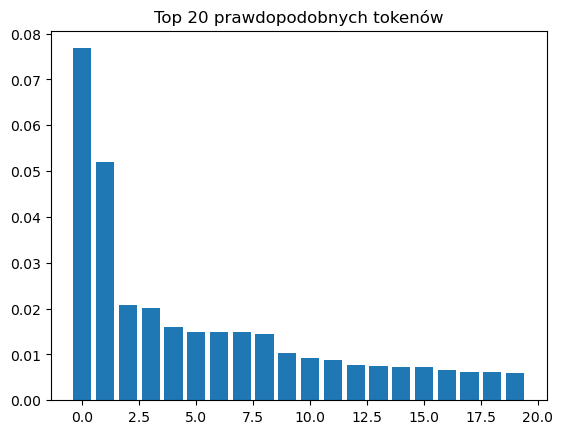

=====in ABBBA the count of letter B is=====
Token: 1
Probability:0.04888760298490524
Token: the
Probability:0.03198065236210823
Token: 0
Probability:0.023611119017004967
Token: not
Probability:0.023587893694639206
Token: equal
Probability:0.023061353713274002
Token: 5
Probability:0.016412317752838135
Token: in
Probability:0.016082478687167168
Token: a
Probability:0.014862855896353722
Token: zero
Probability:0.014056955464184284
Token: 2
Probability:0.014038092456758022
Token::
Probability:0.012442943640053272
Token: 3
Probability:0.011985359713435173
Token: 4
Probability:0.011511444114148617
Token: 6
Probability:0.011253534816205502
Token: 10
Probability:0.010683774016797543
Token: greater
Probability:0.01060718484222889
Token: less
Probability:0.009291008114814758
Token: 9
Probability:0.009219619445502758
Token: as
Probability:0.008907034061849117
Token: 8
Probability:0.00854864064604044


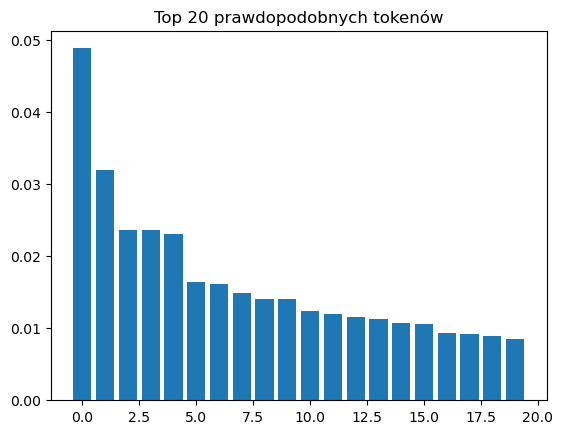

=====statement that the number 2/0 is rational is=====
Token: not
Probability:0.07816904783248901
Token: a
Probability:0.046255361288785934
Token: the
Probability:0.028034329414367676
Token: that
Probability:0.022011445835232735
Token: also
Probability:0.017579341307282448
Token: an
Probability:0.014724553562700748
Token: to
Probability:0.013092593289911747
Token: simply
Probability:0.011079540476202965
Token:,
Probability:0.010699894279241562
Token: based
Probability:0.01066948939114809
Token: false
Probability:0.010633488185703754
Token: misleading
Probability:0.010017476044595242
Token: irrelevant
Probability:0.00919746421277523
Token: incorrect
Probability:0.008980498649179935
Token: wrong
Probability:0.00892578437924385
Token: "
Probability:0.008484356105327606
Token: very
Probability:0.00823436863720417
Token: in
Probability:0.008052769117057323
Token: true
Probability:0.007497821934521198
Token: actually
Probability:0.006884273607283831


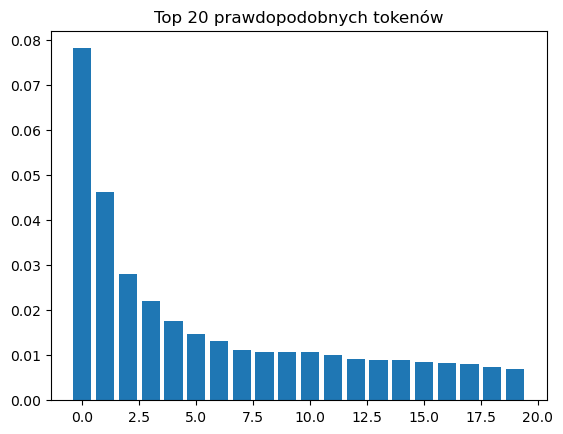

=====Tom's mother has four children: North, South, East, and=====
Token: West
Probability:0.6189093589782715
Token: East
Probability:0.04824133589863777
Token: South
Probability:0.015905754640698433
Token: the
Probability:0.008893164806067944
Token: White
Probability:0.005171175580471754
Token: Down
Probability:0.00490135233849287
Token: North
Probability:0.004837971180677414
Token: one
Probability:0.00464500579982996
Token: a
Probability:0.004559022840112448
Token: Little
Probability:0.0034321013372391462
Token: Middle
Probability:0.0034096043091267347
Token: Father
Probability:0.0029656169936060905
Token: Black
Probability:0.002896476536989212
Token: L
Probability:0.0028246776200830936
Token: I
Probability:0.002747229067608714
Token: his
Probability:0.002563338028267026
Token: Daughter
Probability:0.002392668044194579
Token: all
Probability:0.002298900857567787
Token: Central
Probability:0.002197143854573369
Token: New
Probability:0.002177369548007846


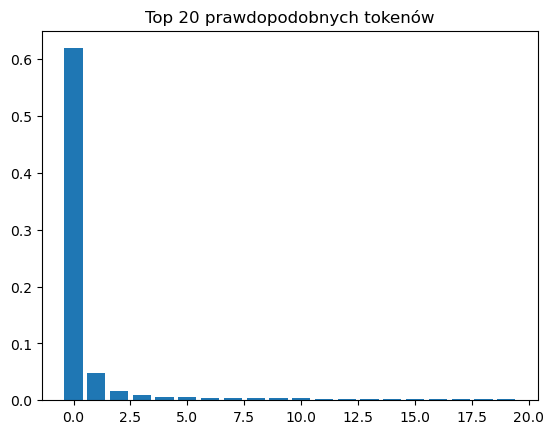

=====the answer to the meaning of life is simply to=====
Token: live
Probability:0.049431733787059784
Token: be
Probability:0.04832903668284416
Token: love
Probability:0.029483728110790253
Token: find
Probability:0.02242165431380272
Token: say
Probability:0.02201903611421585
Token: give
Probability:0.01760433055460453
Token: go
Probability:0.016642030328512192
Token: take
Probability:0.015825388953089714
Token: make
Probability:0.015572908334434032
Token: accept
Probability:0.015517285093665123
Token: do
Probability:0.015117292292416096
Token: have
Probability:0.01413803081959486
Token: keep
Probability:0.013882040046155453
Token: look
Probability:0.013713402673602104
Token: believe
Probability:0.012604303658008575
Token: get
Probability:0.012336867861449718
Token: remember
Probability:0.011697166599333286
Token: ask
Probability:0.011586320586502552
Token: know
Probability:0.011307048611342907
Token: think
Probability:0.010148727335035801


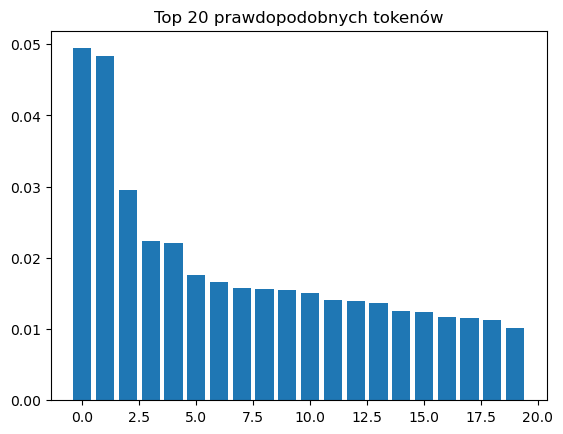

In [9]:
prompts =["The name of the day today is","in ABBBA the count of letter B is","statement that the number 2/0 is rational is", "Tom's mother has four children: North, South, East, and", "the answer to the meaning of life is simply to"]
for p in prompts:
    print(f"====={p}=====")
    inputs = tokenizer.encode(p, return_tensors="pt").to(device)
    
    # Forward pass, bez generacji
    with torch.no_grad():
        outputs = model(inputs)
        logits = outputs.logits  # shape: [1, seq_len, vocab_size]
    
    # Softmax dla ostatniego tokena
    import torch.nn.functional as F
    last_token_logits = logits[0, -1, :]
    probs = F.softmax(last_token_logits, dim=int(-1))
    
    # 100 najbardziej prawdopodobnych tokenów
    top_k = torch.topk(probs, 20)
    for token_id, prob in zip(top_k.indices.tolist(), top_k.values.tolist()):
        print(f"Token:{tokenizer.decode([token_id])}\nProbability:{prob}")
    plt.bar(range(20), top_k.values.cpu().numpy())
    plt.title("Top 20 prawdopodobnych tokenów")
    plt.show()

Na podstawie tego możemy wywnioskować, że GPT-2 nie ma pojęcia, czym jest prawda, ani czym jest kłamstwo. On tylko przewiduje, co najlepiej pasuje do wzorca. To, że GPT-2 "kłamie", wynika z tego, że on nie sprawdza faktów, tylko minimalizuje funkcję straty (szuka słowa, które najmniej "boli" statystycznie w danym kontekście).

* Prompt "The name of the day today is" - model wstawi losowy dzień tygodnia, zależnie od tego, co częściej występowało w jego danych treningowych na początku zdań. GPT-2 jest modelem zamrożonym w czasie, nie ma dostępu do zegara systemowego, kalendarza ani internetu.
  
* Prompt: "in ABBBA the count of letter B is" - model podaje błędną liczbę np. 1, 0, 5. Wynika to z tego, że model nie widzi liter, widzi tokeny.

  
* Prompt: "Tom's mother has four children: North, South, East, and" - poprawna odpowiedź logicznie to Tom, ale model podaje odpowiedź West. Wynika to z tego, że w danych na których model się uczył, sekwencja "North, South, East" występuje w towarzystwie "West" miliony razy. Sekwencja łącząca te kierunki z imieniem Tom występuje tylko w zagadkach.

<h2>5. Zmiana rozkładu prawdopodobieństwa przez sterowanie temperaturą</h2>

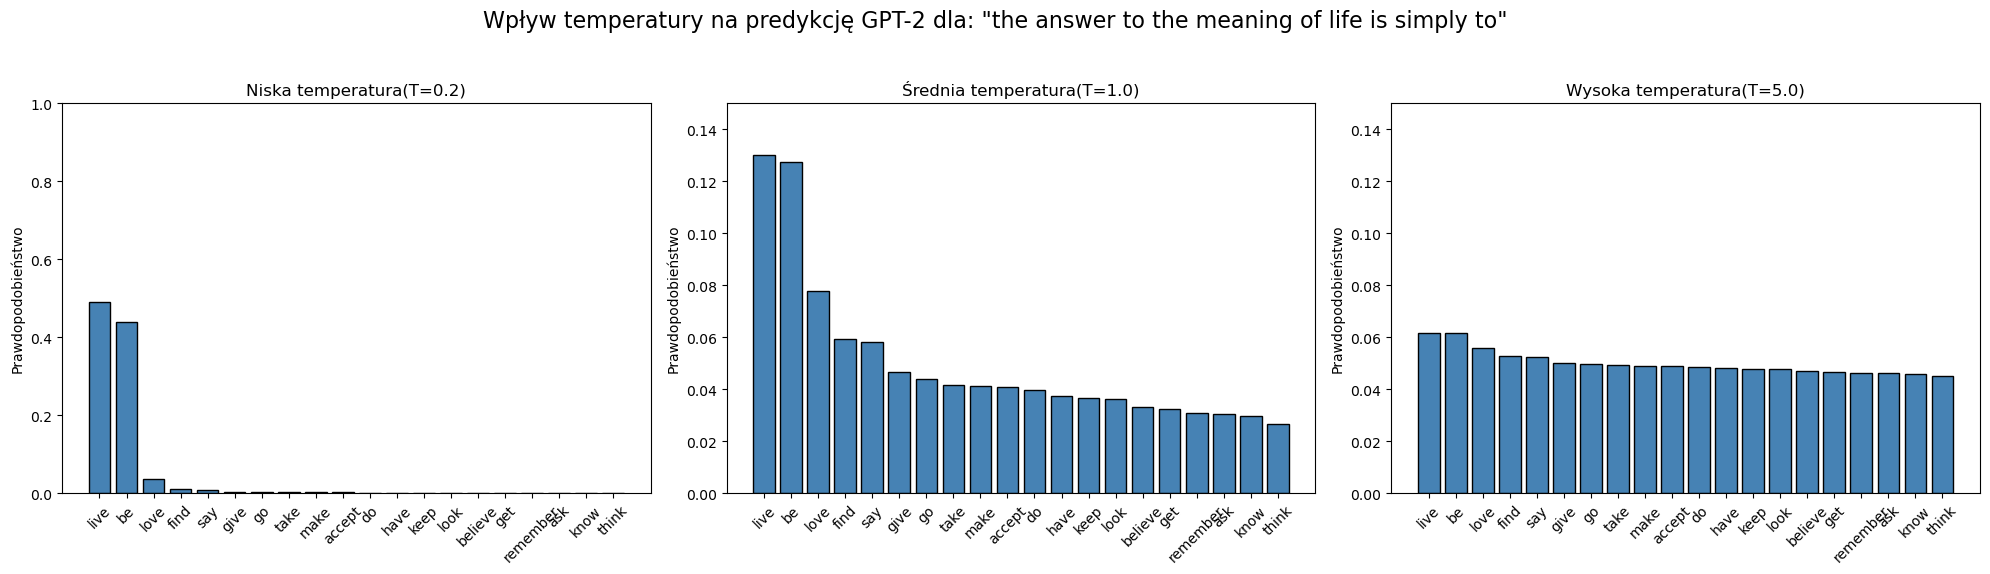

In [10]:
tokens = ["live", "be", "love", "find", "say", "give", "go", "take", "make", "accept", "do", "have", "keep", "look", "believe", "get", "remember", "ask", "know", "think"]
probs = np.array([    0.049431733787059784, 0.04832903668284416, 0.029483728110790253, 0.02242165431380272,
    0.02201903611421585, 0.01760433055460453, 0.016642030328512192, 0.015825388953089714,
    0.015572908334434032, 0.015517285093665123, 0.015117292292416096, 0.01413803081959486,
    0.013882040046155453, 0.013713402673602104, 0.012604303658008575, 0.012336867861449718,
    0.011697166599333286, 0.011586320586502552, 0.011307048611342907, 0.010148727335035801], dtype=float)

logits = np.log(probs)

def softmax_with_temperature(logits, T):
    scaled_logits = logits / float(T)
    e_x = np.exp(scaled_logits - np.max(scaled_logits))
    return e_x / e_x.sum()

temperatures = [0.2, 1.0, 5.0]
labels = ['Niska temperatura(T=0.2)', 'Średnia temperatura(T=1.0)', 'Wysoka temperatura(T=5.0)']

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, T in enumerate(temperatures):
    new_probs = softmax_with_temperature(logits, T)
    axs[i].bar(tokens, new_probs, color='steelblue', edgecolor='black')
    axs[i].set_title(labels[i], fontsize=12)
    axs[i].set_ylabel('Prawdopodobieństwo')
    axs[i].tick_params(axis='x', rotation=45)
    
    if T < 1:
        axs[i].set_ylim(0, 1.0)
    else:
        axs[i].set_ylim(0, 0.15) 

plt.suptitle('Wpływ temperatury na predykcję GPT-2 dla: "the answer to the meaning of life is simply to"', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

W procesie generowania tekstu model GPT nie wybiera słów bezpośrednio. Ostatnia warstwa sieci produkuje wektor surowych wyników, zwanych logitami ($z$). Aby zamienić je na prawdopodobieństwa, stosujemy funkcję Softmax. Parametr temperatury ($T$) pozwala nam matematycznie modyfikować ten rozkład przed dokonaniem wyboru. Temperatura działa jako skalar dzielący logity. Zmodyfikowany wzór na prawdopodobieństwo $P$ dla $i$-tego tokenu wygląda następująco:$$P(x_i) = \frac{\exp\left(\frac{zi}{T}\right)}{\sum{j} \exp\left(\frac{z_j}{T}\right)}$$gdzie:
$z_i$ – logit przypisany do konkretnego słowa w słowniku,

$T$ – parametr temperatury ($T > 0$)

$\exp$ – funkcja wykładnicza, która sprawia, że różnice w logitach przekładają się na drastyczne różnice w prawdopodobieństwie.

* Niska temperatura ($T \to 0$): Gdy $T$ maleje, różnica między największym logitem a pozostałymi zostaje ekstremalnie wyolbrzymiona. Prawdopodobieństwo dla najlepszego słowa dąży do $1$, a dla pozostałych do $0$. Jest to tzw. greedy decoding (dekodowanie zachłanne). Model wybiera najbardziej prawdopodobne odpowiedzi.

* Neutralna temperatura ($T = 1$): Logity pozostają bez zmian. Wykorzystujemy czysty rozkład prawdopodobieństwa wyuczony podczas treningu.

* Wysoka temperatura ($T \to \infty$): Dzielenie przez bardzo dużą wartość sprawia, że wszystkie logity dążą do zera ($z_i/T \approx 0$). Rozkład staje się jednostajny ($P(xi) \approx \frac{1}{n{vocab}}$). Każde słowo ma taką samą szansę na wybór, co generuje kreatywny chaos lub bełkot.

---

<center><h4>Dziękujemy za interesujący temat projektu, zainspirował nas do dalszego rozwoju w kierunku Deep Learningu</h4></center>